In [1]:
from __future__ import division
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

#define matplotlib styles
matplotlib.style.use('fivethirtyeight')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (14,8)
matplotlib.rcParams['xtick.labelsize'] = "large"
matplotlib.rcParams['ytick.labelsize'] = "large"

In [2]:
train = pd.read_json('train.json')
test = pd.read_json('test.json')



stemmer = WordNetLemmatizer()

train.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


In [42]:
for cuisine in list_of_cuisines:
    print "Probs %s: %.2f" % (cuisine,train[train.cuisine == cuisine].shape[0]/len(train))

Probs greek: 0.03
Probs southern_us: 0.11
Probs filipino: 0.02
Probs indian: 0.08
Probs jamaican: 0.01
Probs spanish: 0.02
Probs italian: 0.20
Probs mexican: 0.16
Probs chinese: 0.07
Probs british: 0.02
Probs thai: 0.04
Probs vietnamese: 0.02
Probs cajun_creole: 0.04
Probs brazilian: 0.01
Probs french: 0.07
Probs japanese: 0.04
Probs irish: 0.02
Probs korean: 0.02
Probs moroccan: 0.02
Probs russian: 0.01


In [4]:
test.shape

(9944, 2)

Number of recipes in the training dataset: 39774
Types of cuisine: 20


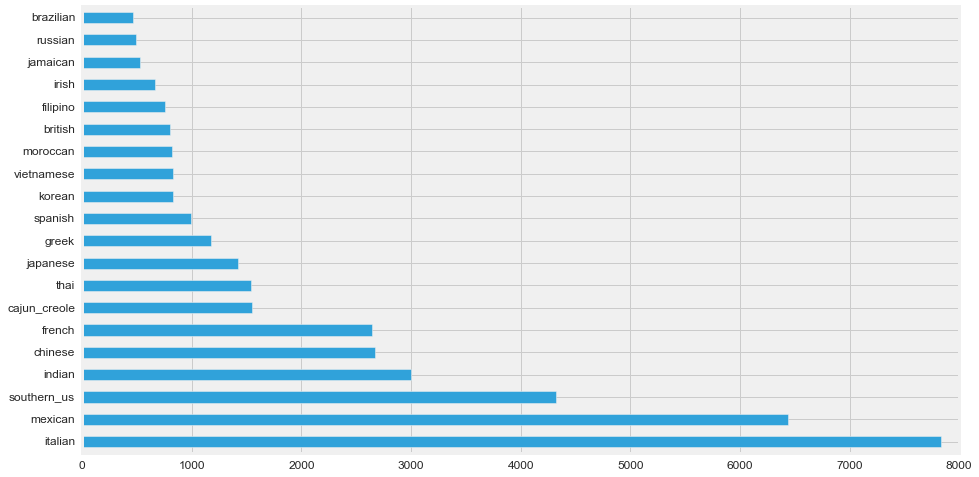

In [5]:
print "Number of recipes in the training dataset: {}".format(len(train))
print "Types of cuisine: {}".format(len(pd.Series.unique(train['cuisine'])))

list_of_cuisines = pd.Series.unique(train['cuisine'])
recipes_per_country = train.cuisine.value_counts()


freq_cuisine_plot = recipes_per_country.plot(kind = 'barh')
freq_cuisine_plot.suptitle = "Recipes per cuisine"

In [17]:
def replace_similar_ingredients(i):
    
    i = i.replace('fresh ', '').replace(' fresh','').replace('diced ','')
    i = i.replace('minced ','').replace('chopped ','').replace('grated ','')
    i = i.replace('garlic cloves','garlic').replace('ground black pepper','black pepper').replace('large eggs','eggs')
    i = i.replace('extravirgin olive oil','olive oil').replace('fresh ginger','ginger').replace('allpurpose flour','flour')
    i = i.replace('vegetable oil', 'oil')
    
    return i


def clean_recipe(recipe):
    
    letterRegex = re.compile('[^a-zA-Z ]')
    recipe = [letterRegex.sub('', i).strip() for i in recipe]
    
    recipe = [ingredient.lower() for ingredient in recipe]
    
    recipe = [replace_similar_ingredients(i) for i in recipe]
    
    recipe = [stemmer.lemmatize(i) for i in recipe]
    
    
    return recipe


In [18]:
train['ingredients_clean'] = train.ingredients.apply(lambda x: clean_recipe(x))
test['ingredients_clean'] = test.ingredients.apply(lambda x: clean_recipe(x))

In [19]:
bag_of_ingred = Counter([ingredient for sublist in train.ingredients_clean for ingredient in sublist])
print len(bag_of_ingred.keys())

6545


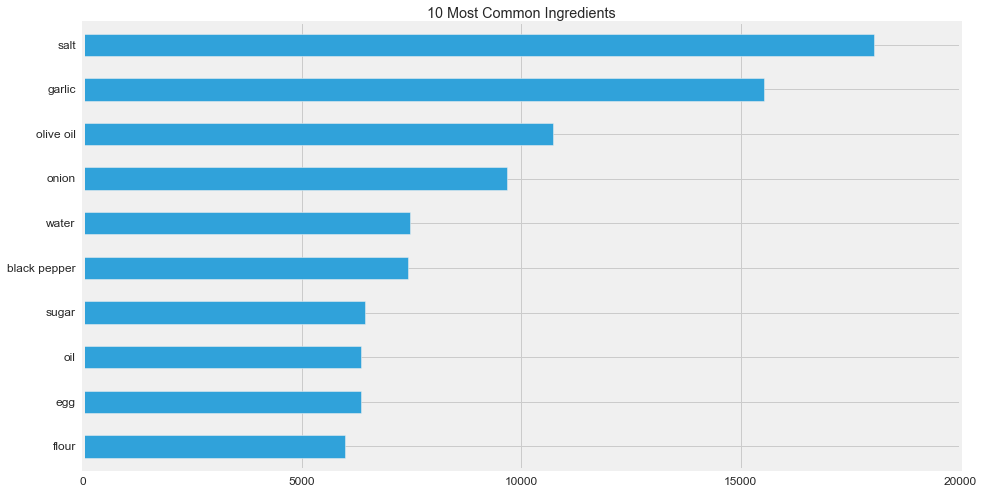

In [20]:
most_common_dict = dict(bag_of_ingred.most_common(10))

most_common_df =  pd.Series(most_common_dict)

most_common_df.sort_values(ascending = True).plot(kind = 'barh')
plt.title("10 Most Common Ingredients")

In [21]:
ingredients_per_cuisine = dict()
ingredients_per_cuisine_norm = dict()

for country in list_of_cuisines:
    ingredients_per_cuisine[country] = Counter([ingredient for sublist in train[train.cuisine==country].ingredients_clean for ingredient in sublist])
    ingredients_per_cuisine_norm[country] = ingredients_per_cuisine[country]



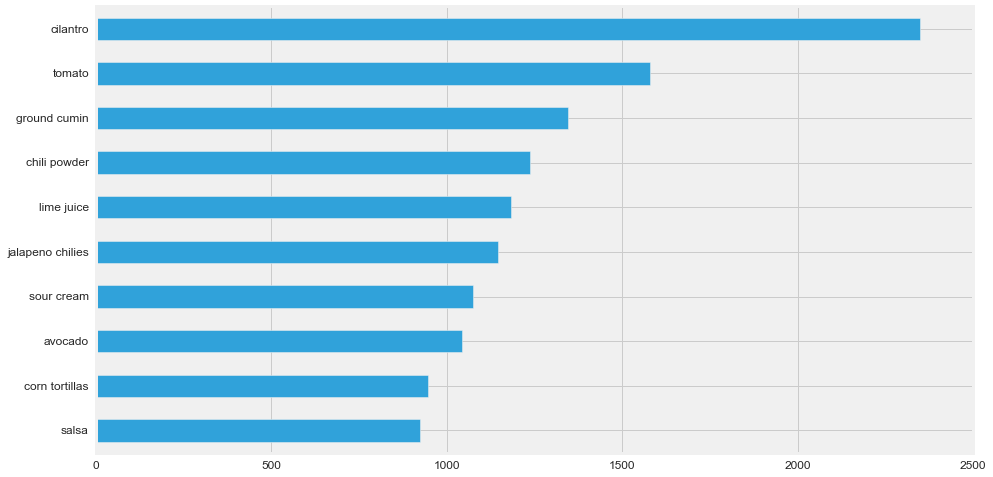

In [38]:
most_common_cuisine_dict = dict(ingredients_per_cuisine['mexican'].most_common(10))

plot1 = pd.Series(most_common_cuisine_dict).sort_values().plot(kind = 'barh')

In [12]:
#train['ingredients_string'] = train.ingredients_clean.apply(lambda x: ' '.join(x))
#test['ingredient_string'] = test.ingredients_clean.apply(lambda x: ' '.join(x))

train['ingredients_string'] = train.ingredients.apply(lambda x: ' '.join(x))
test['ingredient_string'] = test.ingredients.apply(lambda x: ' '.join(x))

In [15]:
corpustr = train['ingredients_string']
vectorizertr = TfidfVectorizer(stop_words='english', ngram_range = ( 1, 1),analyzer="word", 
                               max_df = .6 , binary=False , token_pattern=r'\w+' , sublinear_tf=False, norm = 'l2')


In [16]:
X = vectorizertr.fit_transform(corpustr)

In [19]:
from sklearn.decomposition import PCA

pca = PCA(n_components=20)  
reduced_data = pca.fit_transform(X.toarray())

print(pca.explained_variance_ratio_)
print "Total Variance Explained by the {} components: {}".format(len(pca.explained_variance_ratio_),sum(pca.explained_variance_ratio_))

[ 0.02564523  0.01945185  0.01511771  0.01492903  0.0134953   0.0107012
  0.00980708  0.0095022   0.0090195   0.00842856  0.00802713  0.00774581
  0.00746185  0.0068665   0.00680858  0.0065805   0.00648662  0.00608276
  0.00594379  0.00563548]
Total Variance Explained by the 20 components: 0.203736689271


In [34]:
pca2dataFrame = pd.DataFrame(reduced_data)
pca2dataFrame.columns = ['PC1', 'PC2']

In [16]:
from sklearn.cluster import KMeans

In [17]:
km = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 100, n_init = 10)
km.fit(reduced_data)

labels = km.predict(reduced_data)
centers = km.cluster_centers_

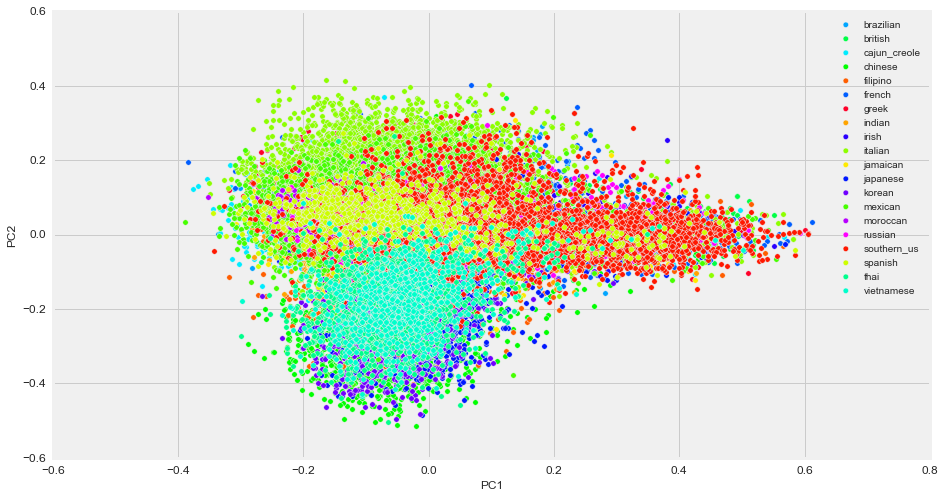

In [48]:
import matplotlib.cm as cm

clusters_df = pd.DataFrame(train['cuisine'], columns = ['Cuisine'])
plot_data = pd.concat([train['cuisine'], pca2dataFrame], axis = 1)

fig, ax = plt.subplots(figsize = (14,8))

cmap = cm.get_cmap('gist_rainbow')

for i, cluster in plot_data.groupby('cuisine'):
    cluster.plot(ax = ax, kind = 'scatter',x = 'PC1', y = 'PC2', s = 30, label = i ,color = cmap((list(list_of_cuisines).index(i))*1.0/len(list_of_cuisines))) 

In [59]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

svd = TruncatedSVD(n_components=4, n_iter=7, random_state=42)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

reduced_data2 = lsa.fit_transform(X)


In [60]:
svd.explained_variance_ratio_

array([ 0.00939768,  0.02219878,  0.01944898,  0.01573718])

array([[ 0.88960142, -0.45673768],
       [ 0.97529985,  0.22088503],
       [ 0.99986266,  0.01657272],
       ..., 
       [ 0.59098442,  0.80668297],
       [ 0.91989528,  0.39216408],
       [ 0.9445327 , -0.32841738]])

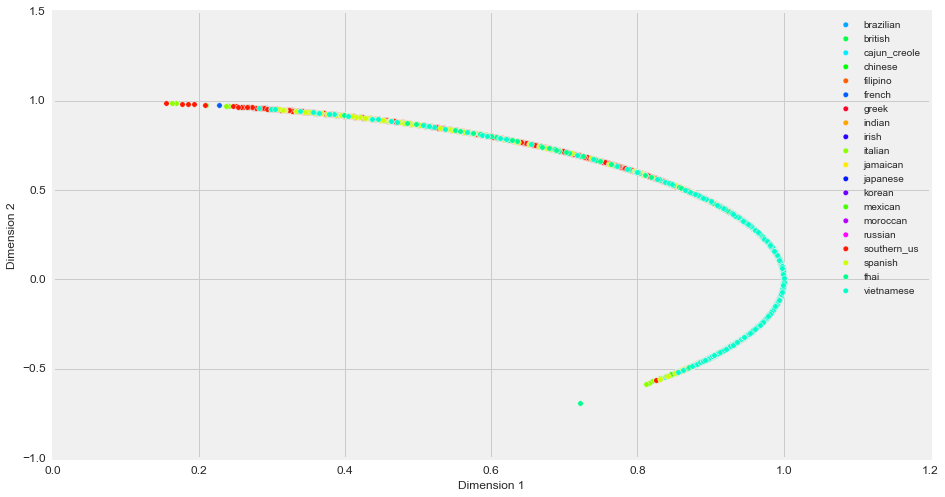

In [54]:
svd2dataFrame = pd.DataFrame(reduced_data2)
svd2dataFrame.columns = ['Dimension 1', 'Dimension 2']

clusters_df = pd.DataFrame(train['cuisine'], columns = ['Cuisine'])
plot_data = pd.concat([train['cuisine'], svd2dataFrame], axis = 1)

fig, ax = plt.subplots(figsize = (14,8))

cmap = cm.get_cmap('gist_rainbow')

for i, cluster in plot_data.groupby('cuisine'):
    cluster.plot(ax = ax, kind = 'scatter',x = 'Dimension 1', y = 'Dimension 2', s = 30, label = i ,color = cmap((list(list_of_cuisines).index(i))*1.0/len(list_of_cuisines))) 



In [61]:
svd2dataFrame = pd.DataFrame(reduced_data2)
svd2dataFrame.columns = ['Dimension 1', 'Dimension 2', 'Dimension 3', 'Dimension 4']

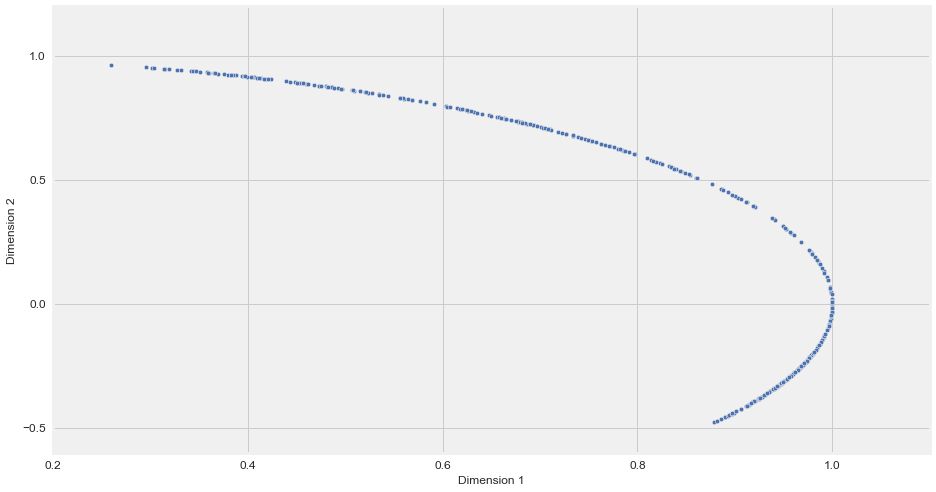

In [23]:
remove_common_list = [ingredient[0] for ingredient in bag_of_ingred.most_common(10)]

In [24]:
remove_common_list

[u'salt',
 u'garlic',
 u'olive oil',
 u'onion',
 u'water',
 u'black pepper',
 u'sugar',
 u'oil',
 u'egg',
 u'flour']

In [25]:
for cuisine in list_of_cuisines:
    for common_ingred in remove_common_list:
        del ingredients_per_cuisine[cuisine][common_ingred]

0